In [1]:
import pandas as pd
import numpy as np
np.random.seed(10)
import math
import copy

from scipy.linalg import solve_discrete_are as ARE

import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

# 1. Define state-space matrices and obtain optimal controls from Bellman equations

In [2]:
# State transition matrix
A = np.array([
    [0.88, 1.388, -0.006, -0.002],
    [-0.001, 0.535, -0.003, -0.002],
    [0, 1.488, 0.993, -0.002],
    [1.877, -4.999, -7.982, 1.005]
])

# Control matrix
B = np.array([
    [-0.011, -0.22],
    [0.083, -0.024],
    [0.092, -0.026],
    [-0.296, -0.144]
])

# Observation matrix
H = np.eye(4)

# Observation noise matrix
G = np.array([
    [0.01, 0, 0, 0],
    [0, 0.03, 0, 0],
    [0, 0, 0.012, 0],
    [0, 0, 0, 0.04]
])

# Functional state matrix
D = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, np.sqrt(10), 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

# Functional Control matrix
F = np.array([
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [1, 0],
    [0, 1],
])

# Get S and M
S_101 = np.zeros((4,4))
next_S = copy.deepcopy(S_101)
S_M_vec = []
for k in [100-x for x in range(101)]:
    # Get S(k) from S(k+1) and system matrices
    S_k = A.T@next_S@A + D.T@D - (A.T@next_S@B + D.T@F)@np.linalg.inv(B.T@next_S@B + F.T@F)@(A.T@next_S@B + D.T@F).T
    
    # Get M(k) from S(k+1) and system matrices
    M_k = np.linalg.inv(B.T@next_S@B + F.T@F)@(A.T@next_S@B + D.T@F).T
    S_M_vec.append((k, S_k, M_k))
    next_S = S_k
S_M_vec = np.flip(S_M_vec, axis=0)

/home/leonardo/py3env/lib/python3.8/site-packages/numpy/lib/function_base.py:334: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m = asarray(m)


## a. Optimal control with state observation

In [3]:
# Simulate state evolution
x_k = np.random.normal(0,1, (4,1))
x_k_a = copy.deepcopy(x_k)
x_df = pd.DataFrame()
for k, S_k, M_k in S_M_vec:
    # Get control
    u_k = -M_k@x_k
    
    # Save state info
    x_df = pd.concat(
        [
            x_df,
            pd.DataFrame(
                data={
                    'k': 6*[k],
                    'variable': ['W_k', 'q_k', 'theta_k', 'h_k', 'deltab_k', 'deltas_k'],
                    'value': [
                        x_k[0][0],
                        x_k[1][0],
                        x_k[2][0],
                        x_k[3][0],
                        u_k[0][0],
                        u_k[1][0]
                    ],
                    'is_state': [True, True, True, True, False, False]
                }
            )
        ]
    )
    # Get next state and update
    next_x = A@x_k + B@u_k
    x_k = next_x

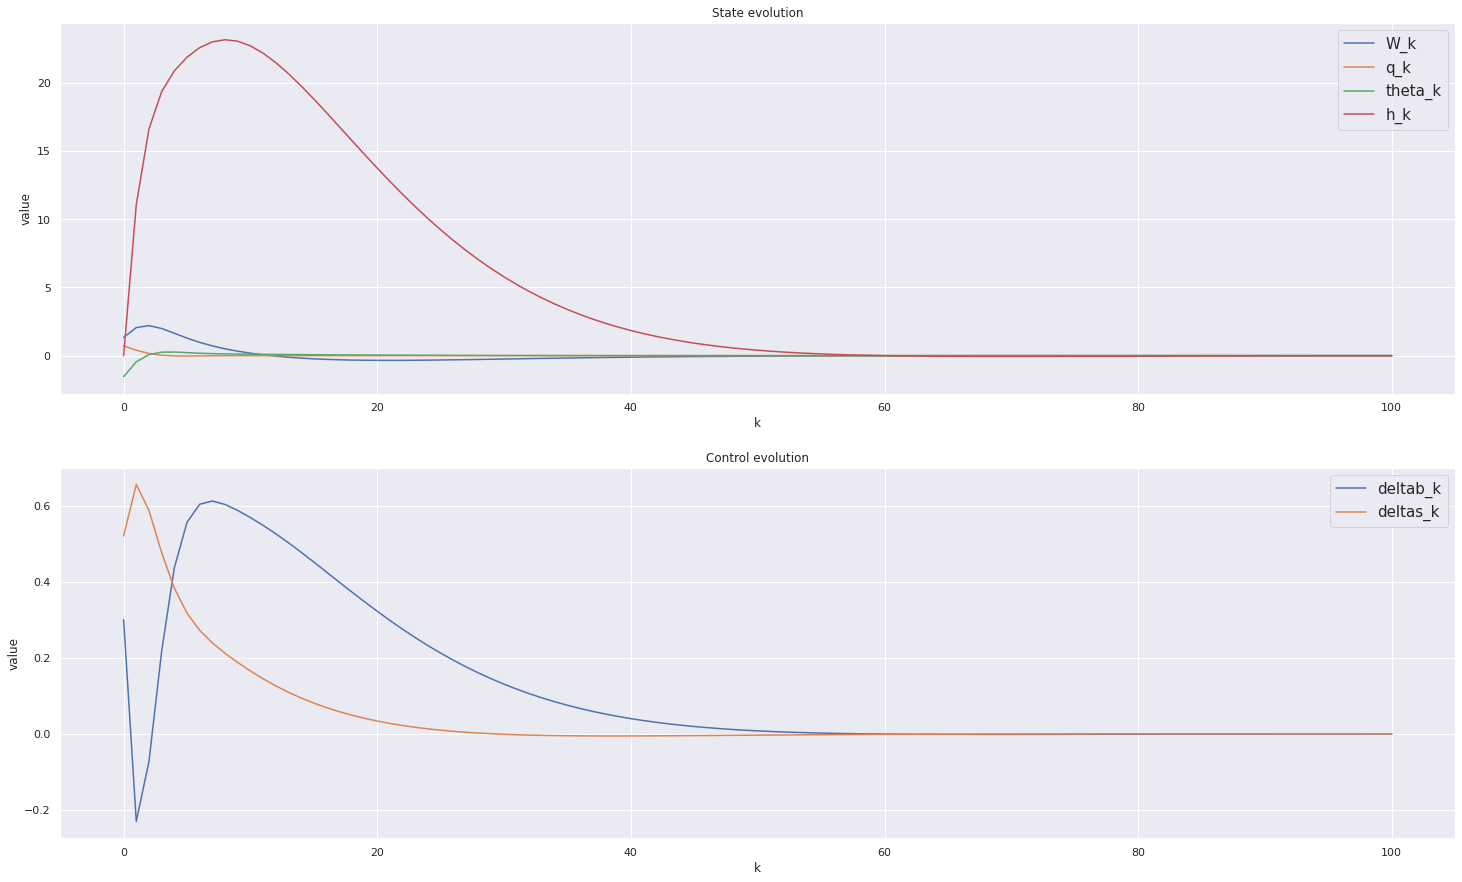

In [4]:
# Get plots
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(25,15)
)

# Ax1
sns.lineplot(
    data=x_df[x_df.is_state],
    x='k',
    y='value',
    hue='variable',
    ax=ax1
)
ax1.set_title('State evolution')
ax1.legend(fontsize=15)

# Ax2
sns.lineplot(
    data=x_df[~x_df.is_state],
    x='k',
    y='value',
    hue='variable',
    ax=ax2
)
ax2.set_title('Control evolution')
ax2.legend(fontsize=15)


## b. Optimal control without state observation (finite time horizon) and Kalman filtering

In [5]:
# Obtaining Kalman Gain for iterations
P_k = np.eye(4)
Q_vec = []
for k in range(101):
    # Get gain
    Q_k = (A@P_k@np.transpose(H))@np.linalg.inv(H@P_k@np.transpose(H) + G@np.transpose(G))
    Q_vec.append(Q_k)
    
    # Update covariance for next iteration
    P_k = A@P_k@(A.T) - (A@P_k@(H.T))@np.linalg.inv(H@P_k@(H.T) + G@(G.T))@np.transpose(A@P_k@(H.T))

In [6]:
# Simulate real system and apply Kalman Gains
x0 = np.random.normal(0,1, (4,1))
e0 = np.random.normal(0,1, (4,1))
u0 = np.zeros((2,1))
y0 = H@x0 + G@e0
x_k_est = A@x0 + B@u0
x_k_est_b = copy.deepcopy(x_k_est)
x_df = pd.DataFrame()
for k, S_k, M_k in S_M_vec:
    # Get control
    u_k = -M_k@x_k_est
    
    # Save state info
    x_df = pd.concat(
        [
            x_df,
            pd.DataFrame(
                data={
                    'k': 6*[k],
                    'variable': ['W_k', 'q_k', 'theta_k', 'h_k', 'deltab_k', 'deltas_k'],
                    'value': [
                        x_k_est[0][0],
                        x_k_est[1][0],
                        x_k_est[2][0],
                        x_k_est[3][0],
                        u_k[0][0],
                        u_k[1][0]
                    ],
                    'is_state': [True, True, True, True, False, False]
                }
            )
        ]
    )
    # Get next state and update
    next_x = A@x_k_est + B@u_k
    y_k = H@next_x + G@np.random.normal(0,1, (4,1))
    
    # Get next state estimate
    x_k_est = A@x_k_est + B@u_k + Q_vec[k]@(y_k - H@x_k_est)
    

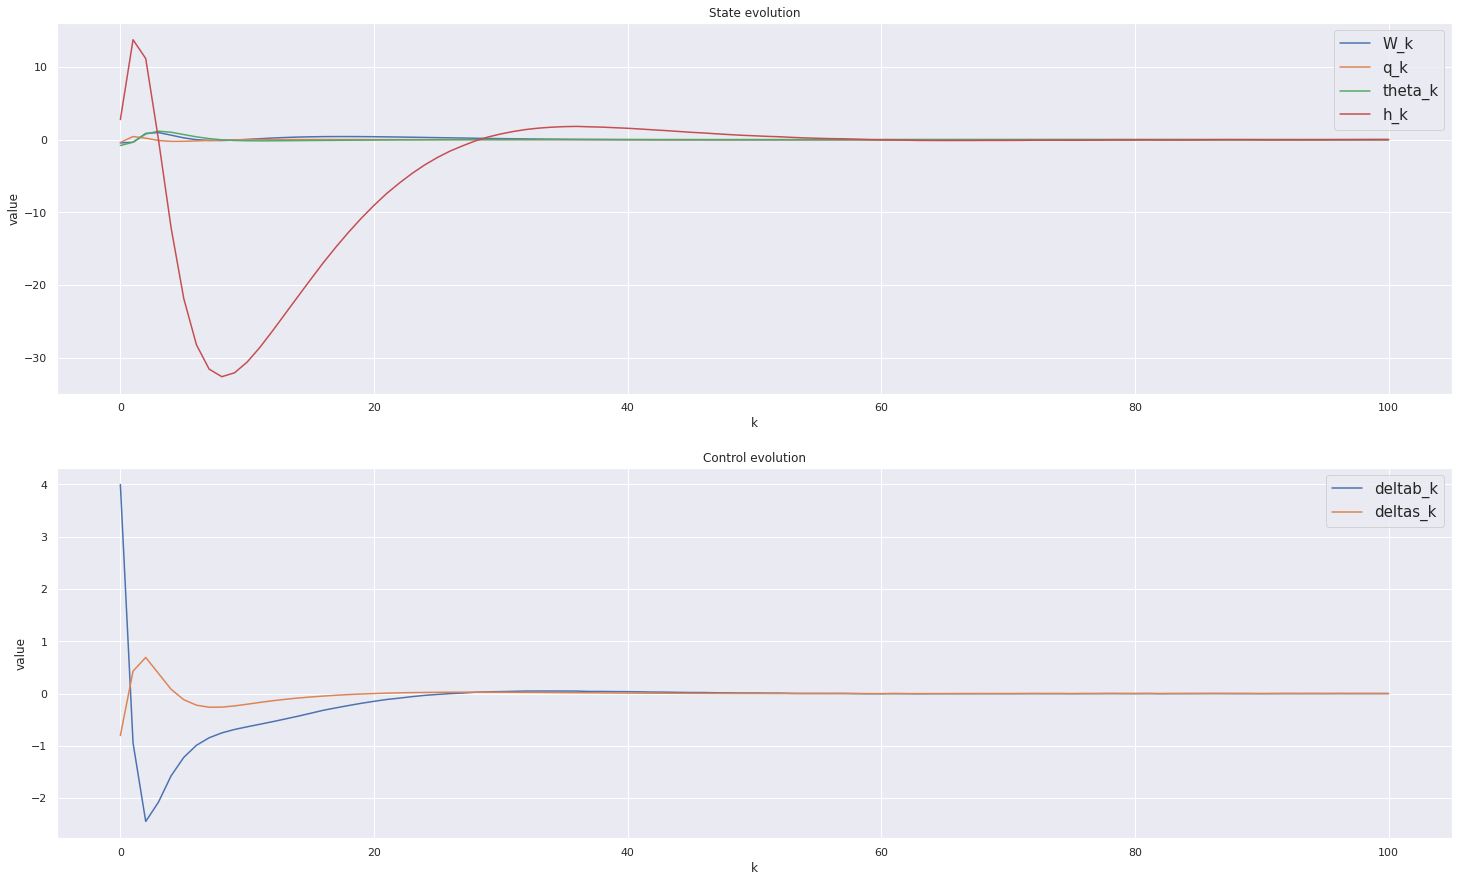

In [7]:
# Get plots
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(25,15)
)

# Ax1
sns.lineplot(
    data=x_df[x_df.is_state],
    x='k',
    y='value',
    hue='variable',
    ax=ax1
)
ax1.set_title('State evolution')
ax1.legend(fontsize=15)

# Ax2
sns.lineplot(
    data=x_df[~x_df.is_state],
    x='k',
    y='value',
    hue='variable',
    ax=ax2
)
ax2.set_title('Control evolution')
ax2.legend(fontsize=15)


## c. Stationary optimal controls and Kalman gains

In [8]:
# Params for stationary S ARE
A_ARE = A
Q_ARE = D.T@D
B_ARE = B
S_ARE = D.T@F
R_ARE = F.T@F

# Solve discrete ARE for S
S_inf = ARE(
    a=A_ARE,
    b=B_ARE,
    q=Q_ARE,
    r=R_ARE,
    e=None,
    s=S_ARE
)

# Get M_inf from S_inf
M_inf = np.linalg.inv(B.T@S_inf@B + F.T@F)@(A.T@S_inf@B + D.T@F).T

In [9]:
# Params for stationary P ARE
A_ARE = A.T
Q_ARE = np.zeros((4,4))
B_ARE = H.T
R_ARE = G@(G.T)

# Solve discrete ARE for P
P_inf = ARE(
    a=A_ARE,
    b=B_ARE,
    q=Q_ARE,
    r=R_ARE,
    e=None,
    s=None
)

# Get Q_inf from P_inf
Q_inf = (A@P_inf@np.transpose(H))@np.linalg.inv(H@P_inf@np.transpose(H) + G@np.transpose(G))

In [10]:
# Simulate real system and apply Kalman Gains
x_k_est = x_k_est_b
x_df = pd.DataFrame()
for k in range(101):
    # Get control
    u_k = -M_inf@x_k_est
    
    # Save state info
    x_df = pd.concat(
        [
            x_df,
            pd.DataFrame(
                data={
                    'k': 6*[k],
                    'variable': ['W_k', 'q_k', 'theta_k', 'h_k', 'deltab_k', 'deltas_k'],
                    'value': [
                        x_k_est[0][0],
                        x_k_est[1][0],
                        x_k_est[2][0],
                        x_k_est[3][0],
                        u_k[0][0],
                        u_k[1][0]
                    ],
                    'is_state': [True, True, True, True, False, False]
                }
            )
        ]
    )
    # Get next state and update
    next_x = A@x_k_est + B@u_k
    y_k = H@next_x + G@np.random.normal(0,1, (4,1))
    
    # Get next state estimate
    x_k_est = A@x_k_est + B@u_k + Q_inf@(y_k - H@x_k_est)
    

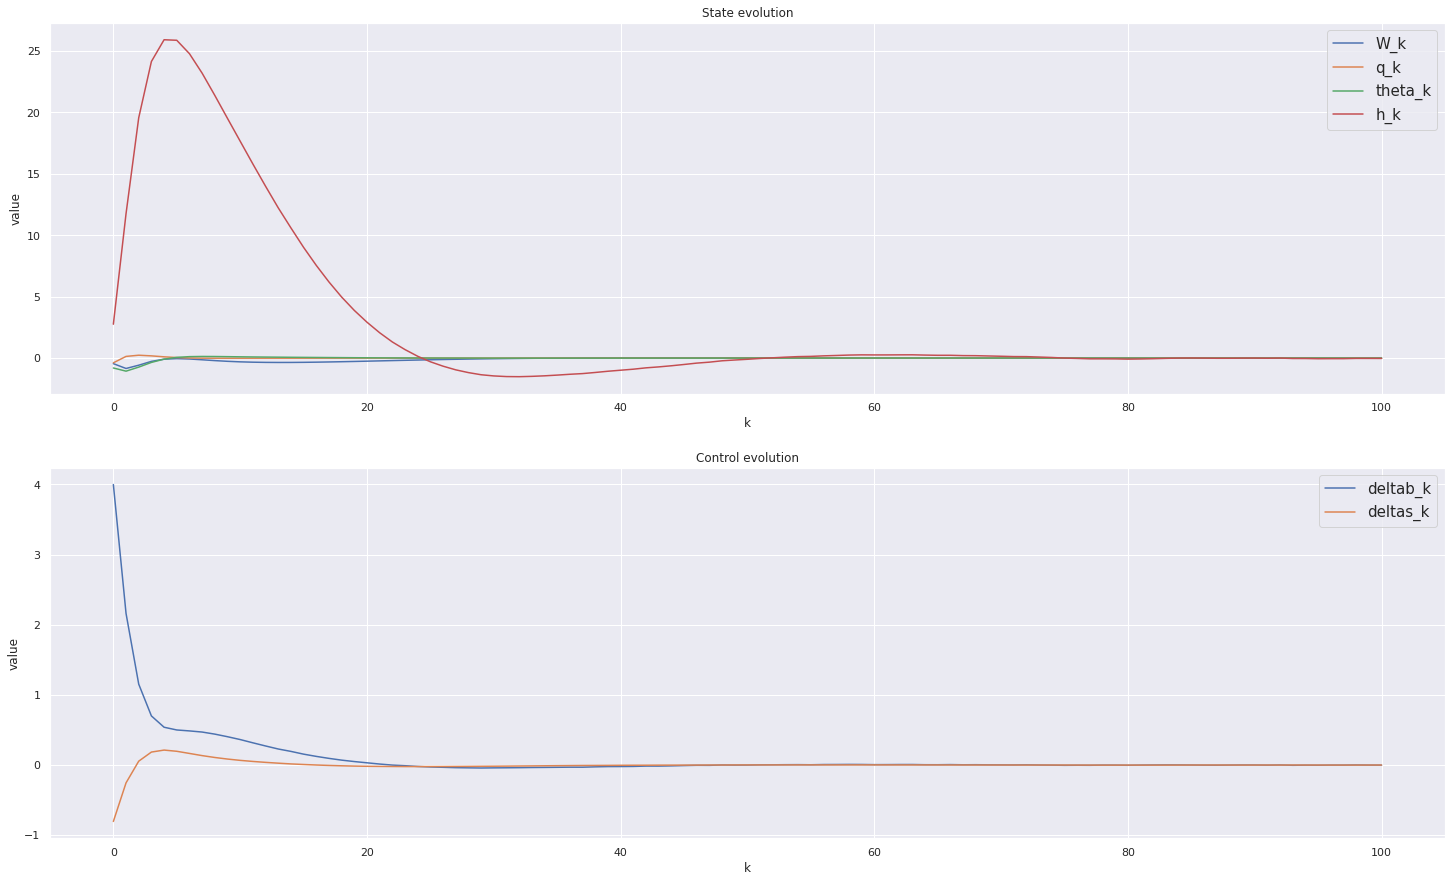

In [11]:
# Get plots
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(25,15)
)

# Ax1
sns.lineplot(
    data=x_df[x_df.is_state],
    x='k',
    y='value',
    hue='variable',
    ax=ax1
)
ax1.set_title('State evolution')
ax1.legend(fontsize=15)

# Ax2
sns.lineplot(
    data=x_df[~x_df.is_state],
    x='k',
    y='value',
    hue='variable',
    ax=ax2
)
ax2.set_title('Control evolution')
ax2.legend(fontsize=15)


## d. Discounted optimal controls with infinite time horizon and state observation

In [12]:
# Discount
rho = 0.95

# Params for stationary S ARE
A_ARE = np.sqrt(rho)*A
Q_ARE = D.T@D
B_ARE = np.sqrt(rho)*B
S_ARE = D.T@F
R_ARE = F.T@F

# Solve discrete ARE for S
S_inf = ARE(
    a=A_ARE,
    b=B_ARE,
    q=Q_ARE,
    r=R_ARE,
    e=None,
    s=S_ARE
)

# Get M_inf from S_inf
M_inf = np.linalg.inv(B.T@S_inf@B + F.T@F)@(A.T@S_inf@B + D.T@F).T

In [13]:
# Simulate state evolution
x_k = x_k_a
x_df = pd.DataFrame()
for k in range(101):
    # Get control
    u_k = -M_inf@x_k
    
    # Save state info
    x_df = pd.concat(
        [
            x_df,
            pd.DataFrame(
                data={
                    'k': 6*[k],
                    'variable': ['W_k', 'q_k', 'theta_k', 'h_k', 'deltab_k', 'deltas_k'],
                    'value': [
                        x_k[0][0],
                        x_k[1][0],
                        x_k[2][0],
                        x_k[3][0],
                        u_k[0][0],
                        u_k[1][0]
                    ],
                    'is_state': [True, True, True, True, False, False]
                }
            )
        ]
    )
    # Get next state and update
    next_x = A@x_k + B@u_k
    x_k = next_x

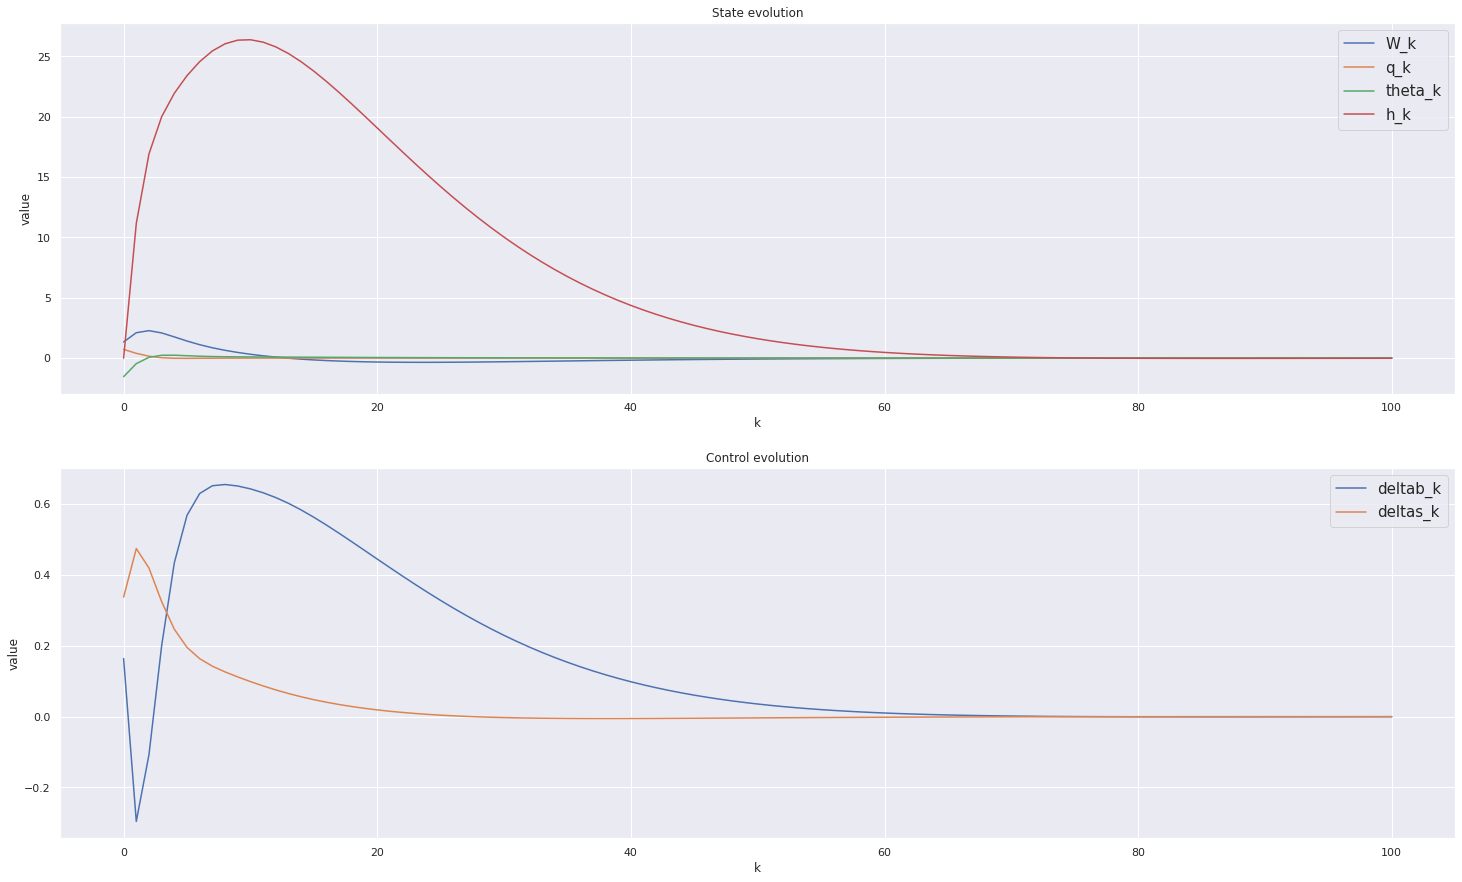

In [14]:
# Get plots
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(25,15)
)

# Ax1
sns.lineplot(
    data=x_df[x_df.is_state],
    x='k',
    y='value',
    hue='variable',
    ax=ax1
)
ax1.set_title('State evolution')
ax1.legend(fontsize=15)

# Ax2
sns.lineplot(
    data=x_df[~x_df.is_state],
    x='k',
    y='value',
    hue='variable',
    ax=ax2
)
ax2.set_title('Control evolution')
ax2.legend(fontsize=15)
